# Generic Resolution Function (Proof of concept)
In time-of-flight SANS the resolution curves from all the wavelengths contributing to a particular Q value are averaged together, weighted by the number of neutrons detected at each wavelength. Since the resolution width is inversely proportional to wavelength this often gives a curve that is noticeably sharper in the peak and broader in the tails than a simple Gaussian.

The purpose of this notebook is to provide a proof concept for extending SasView with generic resolution function. In the first approximation it has been demonstarted with resolution fuction described by Gaussian curve, which allows for easy comparison with already existing implementation into sasview.

The notebooks goes through following steps:
1. Load CanSAS file using SasView loader
2. Generate Gaussian curves based on dQ values from the file
3. Store generated curves to file (custom format that can be used for testing - not CanSAS yet)
4. Modifies sasmodels resolution functions to use generic resolution
5. Compares generated I(q) obtained with Pinhole1D function and generic resolution 

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.special import erf 
from bumps.names import *
from sasmodels import direct_model
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data
from sasdata.dataloader.loader import Loader
from sasmodels.resolution import Resolution

### Loading latex_smeared data set containing dQ column

In [3]:
loader = Loader()
data = loader.load("latex_smeared.xml")[0]

data.qmin = data.xmin
data.qmax = data.xmax
data.mask = np.isnan(data.y)

q = data.x
I = data.y
dq = data.dx
dI = data.dy

### Generating Gaussians curves using `scipy stats` function

In [4]:
#TODO: We just do it for entire q-range.  
gauss_curves = []
for index, sigma in enumerate(dq):
    gauss_curves.append(stats.norm.pdf(q,q[index],sigma))

Exemplary plot for a single data point

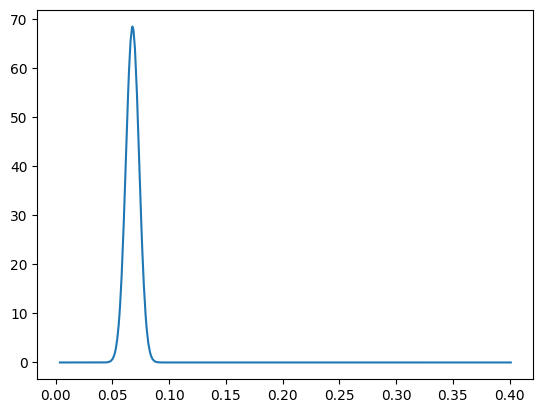

In [5]:
plt.plot(q, gauss_curves[150])

### Save curves to text file (temporary format)

#### General considerations about data format (subject of discussion):

* We presume that a canSAS hdf format file is going to be used.  
* Qdev(Q) should always be provided as before to cope with the usual software
* ResName(Q) allows a switch between numerical curves and analytic fits to curves on a Q by Q basis. This might enable special treatment at extremes of Q, or say around Bragg peaks or other sharp features.

|Description|ResName|ResData|
|-----------|-------|-------|
|Analytic Gaussian|GaussFn|Qdev|
|General, equally spaced|CurveEq|Ndata, V0, V1,V2, …, Vmid, … Vend|
|General, arbitrary spacing|CurveGen|X0, V0, X1, V1, X2, …, Xj, Vj, …., Xend, Vend|
|User supplied|UserRes|FnName, FnData|


Temporary format q, I(q), dq, dI, ResName, Npoints, [Dist data]<br>
<b>Note: Here we are stroring data for all q points, which is clearly overkill as we store many zeros. </b>

In [6]:
f = open("resolution.dat", "w")
first_line = '<q> <I> <dq> <dI> <ResName> <[ResData]>\n'
f.write(first_line)
for index, gauss_curve in enumerate(gauss_curves):
    q_res = [(q[index], res) for index, res in enumerate(gauss_curve)]
    line = f'{q[index]} {I[index]} {dq[index]} {dI[index]} CurveGen {q_res}\n'
    f.write(line)
f.close()

### Modifying sasmodels resolution functions to use generic resolution

In [7]:
#Redifined here for testing purposes
PINHOLE_N_SIGMA = (2.5, 3.0)
MINIMUM_RESOLUTION = 1e-8
MINIMUM_ABSOLUTE_Q = 0.02

def apply_resolution_matrix(weight_matrix, theory):
    """
    Apply the resolution weight matrix to the computed theory function.
    """
    #print("apply shapes", theory.shape, weight_matrix.shape)
    Iq = np.dot(theory[None, :], weight_matrix)
    #print("result shape",Iq.shape)
    return Iq.flatten()


def generic_resolution(weights):
    r"""
    Compute the convolution matrix *W* for generic resolution 1-D data.

    Inspired by pinhole_resolution
    """
    # The current algorithm is a midpoint rectangle rule.  In the test case,
    # neither trapezoid nor Simpson's rule improved the accuracy.
   
    weights /= np.sum(weights, axis=0)[None, :]
    return weights


class Generic1D(Resolution):
    """
    Generic resolution function using weighted matrix input
    """
    def __init__(self, q, weight_matrix):
        self.q = q
        
        #self.q_calc = (pinhole_extend_q(q, q_width, nsigma=nsigma)
        #               if q_calc is None else np.sort(q_calc))
        
        #TODO: Eventually load this from file/data 
        self.weight_matrix = generic_resolution(weight_matrix)
        

    def apply(self, theory):
        return apply_resolution_matrix(self.weight_matrix, theory)


def bin_edges(x):
    """
    Determine bin edges from bin centers, assuming that edges are centered
    between the bins.

    Note: this uses the arithmetic mean, which may not be appropriate for
    log-scaled data.
    """
    if len(x) < 2 or (np.diff(x) < 0).any():
        raise ValueError("Expected bins to be an increasing set")
    edges = np.hstack([
        x[0]  - 0.5*(x[1]  - x[0]),  # first point minus half first interval
        0.5*(x[1:] + x[:-1]),        # mid points of all central intervals
        x[-1] + 0.5*(x[-1] - x[-2]), # last point plus half last interval
        ])
    return edges

def linear_extrapolation(q, q_min, q_max):
    """
    Extrapolate *q* out to [*q_min*, *q_max*] using the step size in *q* as
    a guide.  Extrapolation below uses about the same size as the first
    interval.  Extrapolation above uses about the same size as the final
    interval.

    Note that extrapolated values may be negative.
    """
    q = np.sort(q)
    if q_min + 2*MINIMUM_RESOLUTION < q[0]:
        n_low = int(np.ceil((q[0]-q_min) / (q[1]-q[0]))) if q[1] > q[0] else 15
        q_low = np.linspace(q_min, q[0], n_low+1)[:-1]
    else:
        q_low = []
    if q_max - 2*MINIMUM_RESOLUTION > q[-1]:
        n_high = int(np.ceil((q_max-q[-1]) / (q[-1]-q[-2]))) if q[-1] > q[-2] else 15
        q_high = np.linspace(q[-1], q_max, n_high+1)[1:]
    else:
        q_high = []
    return np.concatenate([q_low, q, q_high])

def pinhole_extend_q(q, q_width, nsigma=PINHOLE_N_SIGMA):
    """
    Given *q* and *q_width*, find a set of sampling points *q_calc* so
    that each point $I(q)$ has sufficient support from the underlying
    function.
    """
    try:
        nsigma_low, nsigma_high = nsigma
    except TypeError:
        nsigma_low = nsigma_high = nsigma
    q_min, q_max = np.min(q - nsigma_low*q_width), np.max(q + nsigma_high*q_width)
    return linear_extrapolation(q, q_min, q_max)

def pinhole_resolution(q_calc, q, q_width, nsigma=PINHOLE_N_SIGMA):
    r"""
    Compute the convolution matrix *W* for pinhole resolution 1-D data.

    Each row *W[i]* determines the normalized weight that the corresponding
    points *q_calc* contribute to the resolution smeared point *q[i]*.  Given
    *W*, the resolution smearing can be computed using *dot(W,q)*.

    Note that resolution is limited to $\pm 2.5 \sigma$.[1]  The true resolution
    function is a broadened triangle, and does not extend over the entire
    range $(-\infty, +\infty)$.  It is important to impose this limitation
    since some models fall so steeply that the weighted value in gaussian
    tails would otherwise dominate the integral.

    *q_calc* must be increasing.  *q_width* must be greater than zero.

    [1] Barker, J. G., and J. S. Pedersen. 1995. Instrumental Smearing Effects
    in Radially Symmetric Small-Angle Neutron Scattering by Numerical and
    Analytical Methods. Journal of Applied Crystallography 28 (2): 105--14.
    https://doi.org/10.1107/S0021889894010095.
    """
    # The current algorithm is a midpoint rectangle rule.  In the test case,
    # neither trapezoid nor Simpson's rule improved the accuracy.
    edges = bin_edges(q_calc)
    #edges[edges < 0.0] = 0.0 # clip edges below zero
    cdf = erf((edges[:, None] - q[None, :]) / (sqrt(2.0)*q_width)[None, :])
    #plt.plot(cdf[:,-1])
    weights = cdf[1:] - cdf[:-1]
    #plt.plot(q, weights[329])
    # Limit q range to (-2.5,+3) sigma
    try:
        nsigma_low, nsigma_high = nsigma
    except TypeError:
        nsigma_low = nsigma_high = nsigma
    qhigh = q + nsigma_high*q_width
    qlow = q - nsigma_low*q_width  # linear limits
    ##qlow = q*q/qhigh  # log limits
    weights[q_calc[:, None] < qlow[None, :]] = 0.
    weights[q_calc[:, None] > qhigh[None, :]] = 0.
    weights /= np.sum(weights, axis=0)[None, :]
    
    return weights

class Pinhole1D(Resolution):
    r"""
    Pinhole aperture with q-dependent gaussian resolution.

    *q* points at which the data is measured.

    *q_width* gaussian 1-sigma resolution at each data point.

    *q_calc* is the list of points to calculate, or None if this should
    be estimated from the *q* and *q_width*.

    *nsigma* is the width of the resolution function.  Should be 2.5.
    See :func:`pinhole_resolution` for details.
    """
    def __init__(self, q, q_width, q_calc=None, nsigma=PINHOLE_N_SIGMA):
        #*min_step* is the minimum point spacing to use when computing the
        #underlying model.  It should be on the order of
        #$\tfrac{1}{10}\tfrac{2\pi}{d_\text{max}}$ to make sure that fringes
        #are computed with sufficient density to avoid aliasing effects.

        # Protect against calls with q_width=0.  The extend_q function will
        # not extend the q if q_width is 0, but q_width must be non-zero when
        # constructing the weight matrix to avoid division by zero errors.
        # In practice this should never be needed, since resolution should
        # default to Perfect1D if the pinhole geometry is not defined.
        self.q, self.q_width = q, q_width
        self.q_calc = (pinhole_extend_q(q, q_width, nsigma=nsigma)
                       if q_calc is None else np.sort(q_calc))

        # Protect against models which are not defined for very low q.  Limit
        # the smallest q value evaluated (in absolute) to 0.02*min
        cutoff = MINIMUM_ABSOLUTE_Q*np.min(self.q)
        self.q_calc = self.q_calc[abs(self.q_calc) >= cutoff]

        # Build weight matrix from calculated q values
        self.weight_matrix = pinhole_resolution(
            self.q_calc, self.q, np.maximum(q_width, MINIMUM_RESOLUTION),
            nsigma=nsigma)

        # Force positive q, even for events measured on the opposite side of
        # the beam stop.
        self.q_calc = abs(self.q_calc)

    def apply(self, theory):
        return apply_resolution_matrix(self.weight_matrix, theory)


### Applying resolution function

In [8]:
pinhole_resolution = Pinhole1D(q, dq)

pars = dict(scale=1, background=0.65, sld=1, sld_solvent=6) 
model = load_model('sphere')

kernel = model.make_kernel([pinhole_resolution.q_calc])
theory = direct_model.call_kernel(kernel, pars)
Iq_pinhole = pinhole_resolution.apply(theory)

kernel.release()

In [9]:
#Will need to use q_extension
generic_resolution = Generic1D(q, np.array(gauss_curves))

In [10]:
pars = dict(scale=1, background=0.65, sld=1, sld_solvent=6) 
model = load_model('sphere')
#model_setup = load_model('sphere')
#resolutuion.q_calc is the same (at least in this case)
kernel = model.make_kernel([generic_resolution.q])
theory = direct_model.call_kernel(kernel, pars)
Iq_generic = generic_resolution.apply(theory)
#kernel.realase()

## 5. Comparing generated I(q) obtained with Pinhole1D function and generic resolution

Text(0, 0.5, 'I(Q) (1/cm)')

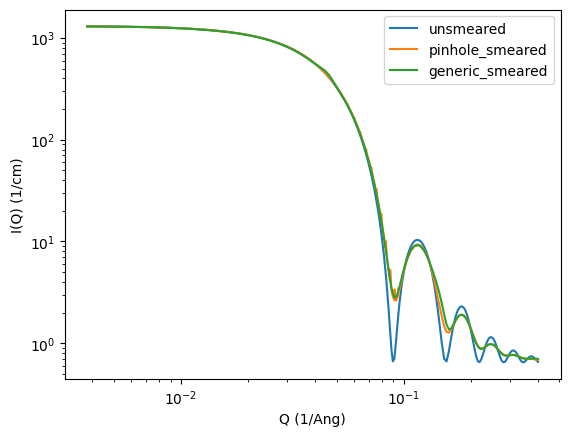

In [11]:
plt.loglog(pinhole_resolution.q, theory, label='unsmeared')
plt.loglog(pinhole_resolution.q, Iq_pinhole, label='pinhole_smeared')
plt.loglog(generic_resolution.q, Iq_generic, label='generic_smeared')

plt.legend()
plt.xlabel("Q (1/Ang)")
plt.ylabel("I(Q) (1/cm)")